# Web Scraping and Introductory Data Analysis

In this homework, we will delve into web scraping and perform an introductory data analysis. It will help us become familiar with the process of extracting data from websites and conducting basic statistical analysis. 


## Objectives

1. Setting up a Python environment with the necessary libraries for web scraping and data analysis
2. Writing a web scraping script using Beautiful Soup and Selenium to collect data from a website
3. Sampling from the collected dataset and compare the statistics of the sample and the population


## Tasks

1. **Environment Setup**: At first, we install the required libraries such as Beautiful Soup, Selenium, pandas, numpy, matplotlib, and seaborn.

2. **Web Scraping**: Then we write a script to scrape transaction data from [Etherscan.io](https://etherscan.io/txs) using Selenium to interact with the website and Beautiful Soup to parse the HTML content. 

To do that, initially we must import necessary libraries that we've installed before.

After that we start the scraping process. At first, we set up the web driver. Then, we navigate to the website listing Ethereum transactions (considering a delay between requests to avoid rate limiting and making sure that block elements are loaded is important). Using Beautiful Soup, parsing the page source will be done. We continue doing this process for next pages (by increasing the page number after saving all of the information in current page) until we collect datas of 10 blocks. To do that, every time that we see a block number that we haven't seen before, we save it in the list of all block numbers and we keep on doing this until the length of that list is 10. During the process of saving information in a data list, we skip unnecessary columns. Finally after collecting every necessary datas, we close the web driver.

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

In [4]:
def find_table(driver, url, page_num):
    driver.get(f"{url}?p={page_num}")
    page_source = driver.page_source
    soup = BeautifulSoup(page_source, 'html.parser')
    table = soup.find("table", attrs={"class": "table table-hover table-align-middle mb-0"})
    return table

def new_block(block_num, row_data, prev_blocks):
    block_num[0] += 1
    prev_blocks.append(row_data[-1])

def is_necessary_data(data_col):
    return data_col != 0 and data_col != 5 and data_col != 6 and data_col != 8 and data_col != 12

def is_new_block_num(data_col, row_data, prev_blocks):
    return data_col == 3 and row_data[-1] not in prev_blocks

def extract_row(row, prev_blocks, block_num):
    data_col, extracted_row = 0, []
    for cell in row.find_all('td'):
        if is_necessary_data(data_col):
            extracted_row.append(cell.text.replace("\n", ""))
        if is_new_block_num(data_col, extracted_row, prev_blocks):
            new_block(block_num, extracted_row, prev_blocks)
        data_col += 1
    return extracted_row
    
def extract_website_data(driver, url):
    all_blocks = False
    block_num, page_num, prev_blocks, data = [0], 1, [], []
    while not all_blocks:
        table = find_table(driver, url, page_num)
        time.sleep(1)
        for row in table.find_all('tr'):
            data.append(extract_row(row, prev_blocks, block_num))
        if block_num[0] > 10:
            all_blocks = True
            break
        page_num += 1
    return data

In [35]:
driver = webdriver.Chrome()
url = "https://etherscan.io/txs"

data = extract_website_data(driver, url)
driver.quit()

In [10]:
def is_necessary_header(header_num):
    return header_num != 0 and header_num != 6

def is_method(header_num):
    return header_num == 2

def extract_header(driver, url):
    header = []
    header_num = 0
    table = find_table(driver, url, 1)
    for cell in table.find('tr').find_all('th'):
        if is_necessary_header(header_num) and not(is_method(header_num)):
            header.append(cell.text.replace("\n", ""))
        elif is_method(header_num):
            header.append(cell.text.replace("\n", "").replace(" ", ""))
        header_num += 1
    return header

driver = webdriver.Chrome()
url = "https://etherscan.io/txs"

header = extract_header(driver, url)
print(header)
driver.quit()  

['Txn Hash', 'Method', 'Block', 'Age', 'From', 'To', 'Value', 'Txn Fee']


3. **Population Data Analysis**: 

Once the data is collected, we clean the data by converting data types, removing any irrelevant information, and handling duplicates and null values. We then save them to a dataframe.

The important data conversion here is converting value and fee from string into float. We do that by removing the "ETH" and " wei" substrings that the value column usually has and removing commas if the number's long enough to have them


In [62]:
def is_element_string(element):
    return isinstance(element, str)

def convert_data(data):
    for row in data:
        if row == []:
            continue
        value = row[6]
        fee = row[7]
        if is_element_string(value):
            row[6] = float(value.replace(",", "").replace(" ETH", "").replace(" wei", ""))
        elif is_element_string(fee):
            row[7] = float(fee.replace(",", ""))
    return data

In [63]:
data = convert_data(data)
df = pd.DataFrame(data, columns=header)
df = df.drop_duplicates()
df = df.dropna()
display(df)

,Txn Hash,Method,Block,Age,From,To,Value,Txn Fee
1,0x1b460f2e4e4e2ba408892f4a091dc16fb5498d2bd7ef...,Transfer,19377564,2024-03-06 17:16:47,titanbuilder.eth,0x373d5576...6Ff5F7f01,0.528248,0.002327
2,0x6d25e1b7fc945622bf2ecceea2ee45811d804db9954e...,Sell To Uniswap,19377564,2024-03-06 17:16:47,0xaad73C97...6B3f8Afc7,0x: Exchange Proxy,0.000000,0.017073
3,0xa6227be6d7c0ac04cf29d8a2479862baa8917a97088a...,Transfer,19377564,2024-03-06 17:16:47,Binance 18,0x291E1F86...D03C21bED,0.031353,0.002369
4,0xa78bce63a0abab824d75d417627ce59ad59aa9dcd403...,Transfer,19377564,2024-03-06 17:16:47,Ramp Network,0x13FfB1eD...27610D297,0.014667,0.002380
5,0x81a7986273c2b19edd463038c6d87cba56e0f1bca1cc...,Transfer,19377564,2024-03-06 17:16:47,Crypto.com 2,Illuvium: ILV Token,0.000000,0.007390
...,...,...,...,...,...,...,...,...
6268,0xdbf8fca1c1a79055a1b6adc4fc345f12604c3b031028...,Transfer,19377556,2024-03-06 17:15:11,0x9Af11341...8d05bd3Fa,Circle: USDC Token,0.000000,0.004753
6269,0x9dafdb9bcf49c799f36a49ccc6bb29f2e23a263d294b...,Transfer,19377556,2024-03-06 17:15:11,0x438319F4...1c357bbF5,Circle: USDC Token,0.000000,0.004753
6270,0xbd3292f95db1bba1a500fcf643df4bfb8e85e4193975...,0xc18f278b,19377556,2024-03-06 17:15:11,0x315D2Ee4...04F8D9EbA,0x738e79fB...f61502221,0.000000,0.004713
6271,0x37e62166d8482409958a16dff35917056a3121edfa87...,Transfer,19377556,2024-03-06 17:15:11,0x00f173B9...B81A185A5,Orbiter Finance: Bridge,0.131500,0.002212


We save the data in a CSV file to avoid the necessity of scraping data for next analysis.

In [39]:
df.to_csv('transaction_data_1.csv', index=False)

We read the CSV file in case that we are repeating the analysis and we don't want to scrape datas again. So in this situation, we can start the process from here.

In [11]:
df = pd.read_csv('transaction_data.csv')
population_size = len(df)
sq_root_of_pop = int(np.ceil(np.sqrt(population_size)))

We calculate mean and standard deviation of values and txn fees.

In [12]:
pop_mean_value = df['Value'].mean()
pop_std_value = df['Value'].std()

pop_mean_fee = df['Txn Fee'].mean()
pop_std_fee = df['Txn Fee'].std()

print(f"Mean of population value: {pop_mean_value}")
print(f"Standard Deviation of population value: {pop_std_value}\n")

print(f"Mean of population Txn Fee: {pop_mean_fee}")
print(f"Standard Deviation of population Txn Fee: {pop_std_fee}")

Mean of population value: 0.49022609499224135
Standard Deviation of population value: 4.405093152322067

Mean of population Txn Fee: 0.005566154887931034
Standard Deviation of population Txn Fee: 0.010348876525458543


We know that 95% confident interval is within 2 standard deviation of mean value. Since standard deviation of values is a great number and mean of values is a small number, we can guess that "mean of values - 2*standard deviation of values" would be a negative number. Since values can't be negative, we can say that values probably have a right skewed distribution.

We can say exactly the same for txn fees. 

To see if our conclusion is correct or not, we'll show some charts:

1. **Histogram (to see the distributions)**: Based on square root rule, we assign the number of bins to the square of sample/population size. This rule aims to strike a balance between capturing the nuances of the dataset and preventing the histogram from becoming too detailed or difficult to interpret due to an excessive number of bins.

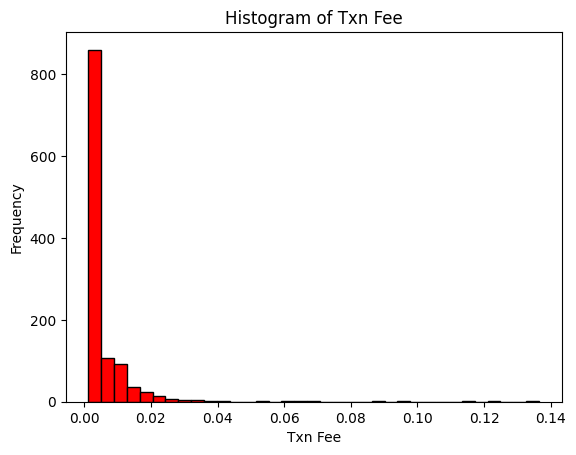

In [13]:
plt.hist(df["Txn Fee"], bins=sq_root_of_pop, color='red', edgecolor='black')
plt.xlabel('Txn Fee')
plt.ylabel('Frequency')
plt.title('Histogram of Txn Fee')
plt.show()

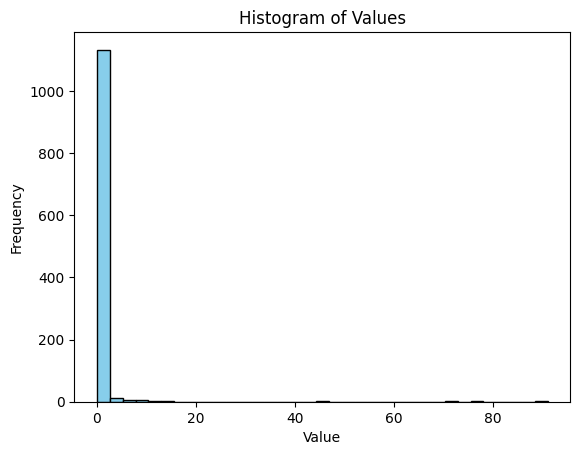

In [14]:
plt.hist(df["Value"], bins=sq_root_of_pop, color='skyblue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()

We can see that nearly all of our data is in the first bin so maybe we need to increase the bin size to improve our visualization.

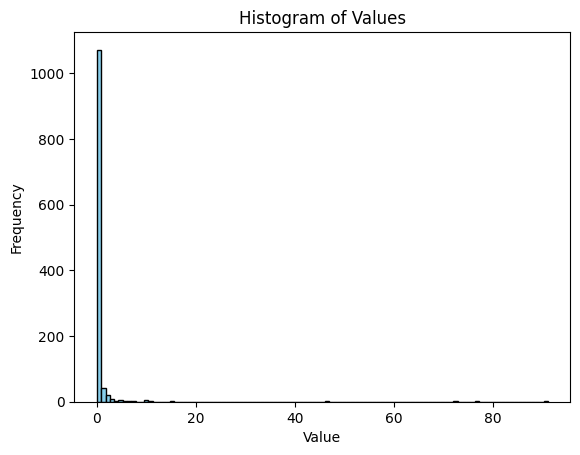

In [15]:
plt.hist(df["Value"], bins=sq_root_of_pop*3, color='skyblue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()

As we can see even if we triple our bin size nearly all of our values are in the first bin which means the value skewness is extremely harsh. Therefore we don't need a larger bin size as it'll only make it more difficult to see the visualization

The problem we have is that the skewness is too high. We normally don't need to fix this as we do need to see the skewness and data distribution of our data and modifying it might make it more difficult to do so. If we really need to reduce it for various reasons like modelling it or viewing the distribution in a new way, we can do a log transformation. 

We must be cautious about data values equal to 0 since log(0) is undefined. To address this, we incorporate a small constant into our data. While this adjustment minimally affects the logarithm of non-zero data values, it allows us to compute the logarithm for previously problematic zero values.

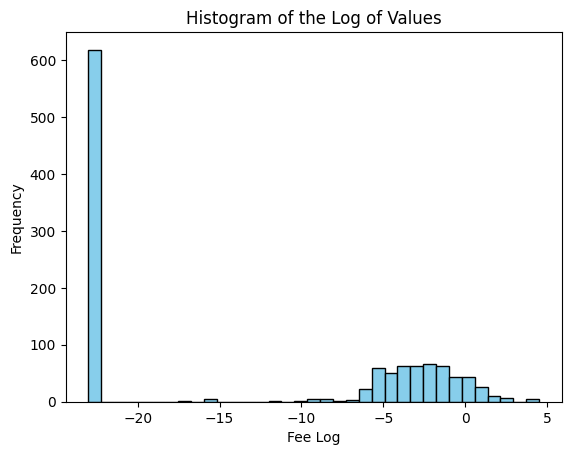

In [16]:
small_constant = 1e-10
df['Value Log'] = df['Value'].apply(lambda x: np.log(x + small_constant))

plt.hist(df["Value Log"], bins=sq_root_of_pop, color='skyblue', edgecolor='black')
plt.xlabel('Fee Log')
plt.ylabel('Frequency')
plt.title('Histogram of the Log of Values')
plt.show()

We can more clearly see that a lot of our values are 0 since they have a very small log. If we theoretically remove the first bin we can also see that our values follow a normal distribution with a few outliers that are on the left 

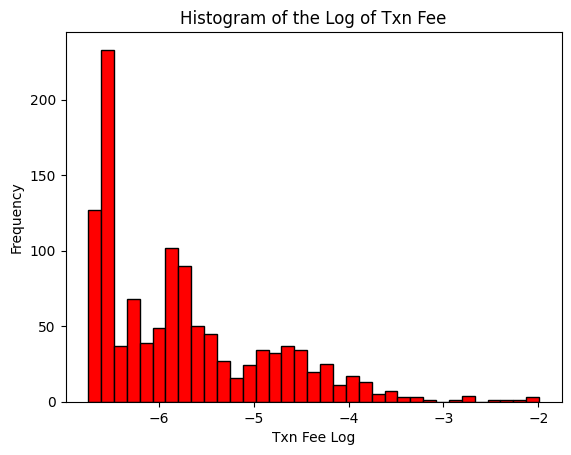

In [17]:
df['Txn Fee Log'] = df['Txn Fee'].apply(lambda x: np.log(x))

plt.hist(df["Txn Fee Log"], bins=sq_root_of_pop, color='red', edgecolor='black')
plt.xlabel('Txn Fee Log')
plt.ylabel('Frequency')
plt.title('Histogram of the Log of Txn Fee')
plt.show()

In this log historgram, we can see that Txn fees are never 0, as we didn't even need to add a small constant. Other than that we can see that our data is quite small fees are never more than 1. We can also see that the density around smaller numbers are quite large, which we also saw in the non-modified histogram.

2. **Normal Distribution Plot Fitted Alongside the Histogram (to see the difference between current distributions with fitted normal distributions)**: 

By employing the density=True setting, the histogram is normalized, ensuring that the cumulative area beneath the histogram bars equals 1. This normalization transforms frequency counts into probability densities.

The probability density function (PDF) values are then computed for a normal distribution with the given mean and standard deviation at each point within the x array. This computation follows the formula of the normal distribution PDF, enabling the derivation of these values.

In a theoretical normal distribution, the concentration of data around the mean is notably lower compared to the empirical distribution. Empirical distributions may exhibit larger standard deviations due to the presence of substantial outliers. Conversely, in a theoretical normal distribution, outliers are absent, and the primary data density resides within the normal curve, falling within the 95% confidence interval.

Moreover, in an empirical distribution, the proximity of high data density to the mean contributes to the inclusion of outliers when calculating the mean. In contrast, a theoretical normal distribution lacks these outliers, so it won't be necessary for there to be a high density of data around the mean during mean calculation.

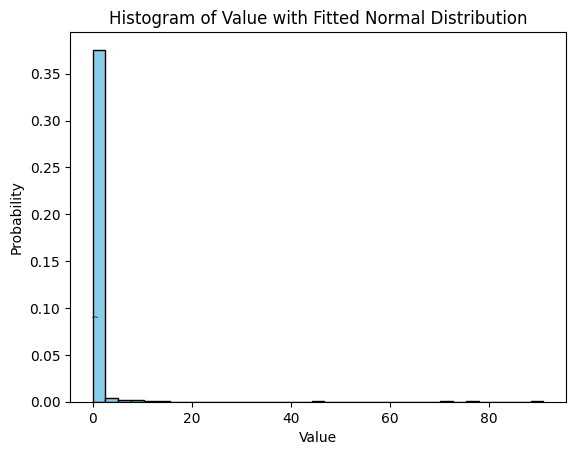

In [18]:
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
calculated_value_pdf = 1 / (pop_std_value * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - pop_mean_value) / pop_std_value) ** 2)

plt.hist(df["Value"], bins=sq_root_of_pop, density=True, color='skyblue', edgecolor='black')
plt.plot(x, calculated_value_pdf, 'k', linewidth=0.5)
plt.title("Histogram of Value with Fitted Normal Distribution")
plt.xlabel("Value")
plt.ylabel("Probability")
plt.show()

In this PDF we can't even see the normal distribution because of the extreme right skewness of our. There's a chance that our value will be in the first bin which proves that most of our data is very close to our mean and explains the low standard deviation as well.

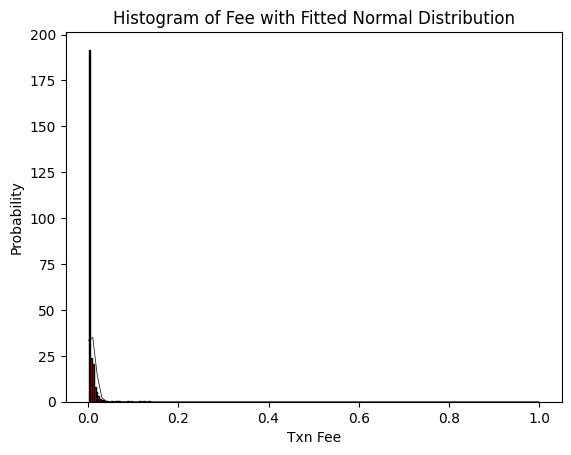

In [19]:
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
calculated_fee_pdf = 1 / (pop_std_fee * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - pop_mean_fee) / pop_std_fee) ** 2)

plt.hist(df["Txn Fee"], bins=sq_root_of_pop, density=True, color='red', edgecolor='black')
plt.plot(x, calculated_fee_pdf, 'k', linewidth=0.5)
plt.title("Histogram of Fee with Fitted Normal Distribution")
plt.xlabel("Txn Fee")
plt.ylabel("Probability")
plt.show()

In an empirical distribution, the greatest concentration of data is observed before and in close proximity to the mean. However, there is a substantial number of data points within the interval "mean + 2 * standard deviation", and the presence of outliers, which are the primary contributors to the elevated standard deviation compared to the mean, contributes to the high-density region.

Even if we subdivide the high-density region into smaller segments and fit them within a 95% confidence interval, the portion of the chart preceding the mean would likely remain larger than the corresponding section of the theoretical normal distribution chart. This discrepancy is attributed to the impact of outliers, which exert a notable influence on the overall distribution and contribute to the observed differences between the empirical and theoretical distributions.

3. **A box plot and a violin plot (to find the quartiles and whiskers and their distance to outliers)**: We divide them into 2 subplots to show them next to each other.

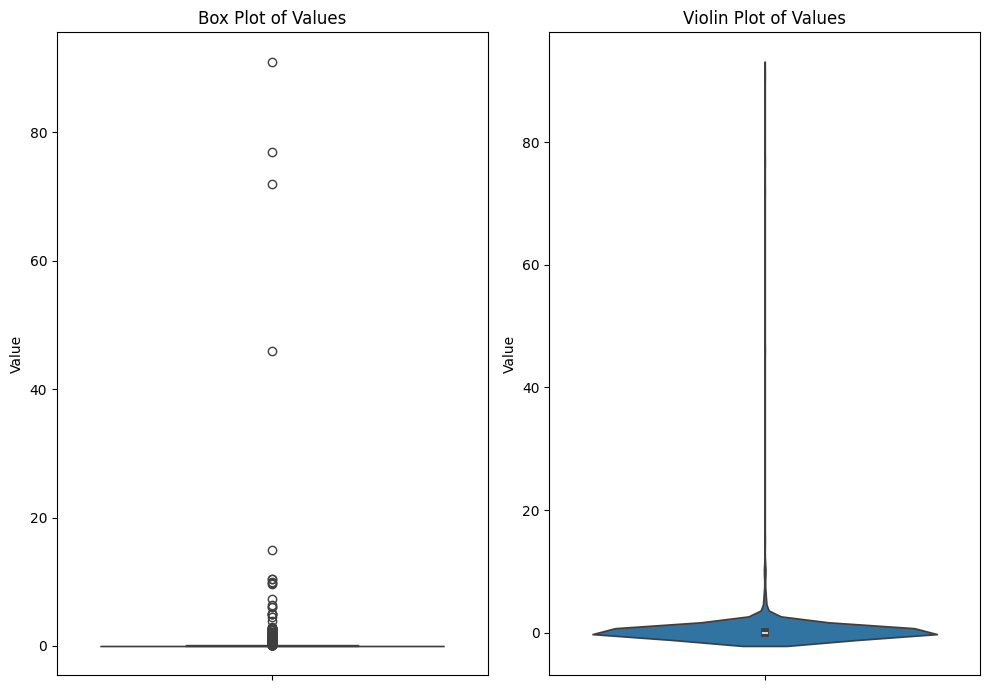

In [20]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(df["Value"])
plt.title("Box Plot of Values")
plt.subplot(1, 2, 2)
sns.violinplot(df["Value"])
plt.title("Violin Plot of Values")
plt.tight_layout()
plt.show()

In these plots, we can see that most of the datas are compressed near zero and mean and first quartile and third quartile are so close to each other near zero that it's hard to recognize them. And there are some outliers that are way larger than mean and upper whisker in the population.

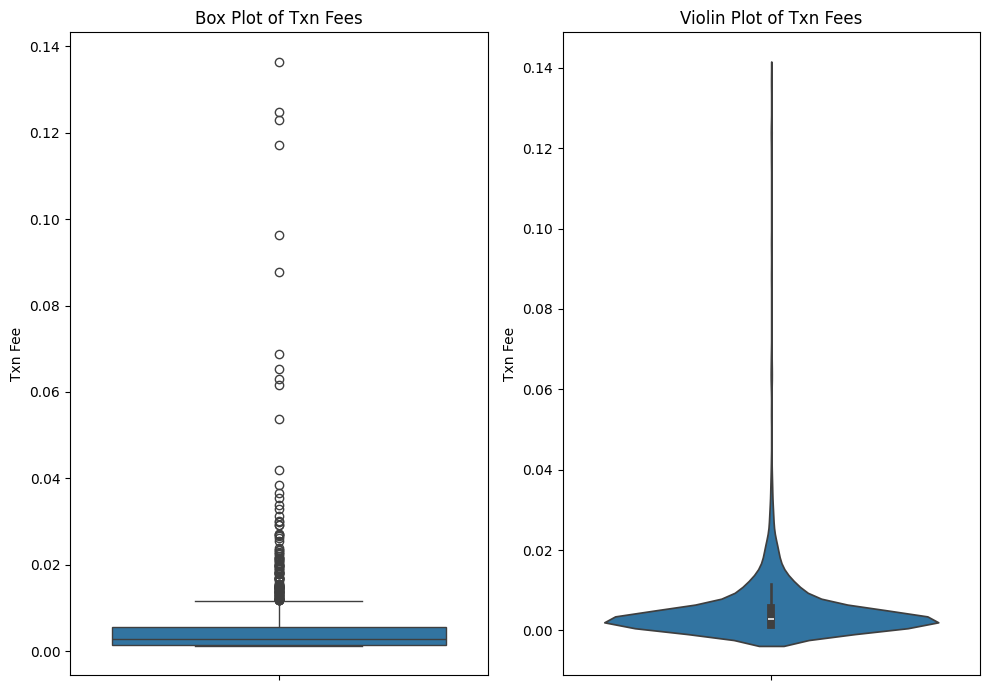

In [21]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(df["Txn Fee"])
plt.title("Box Plot of Txn Fees")
plt.subplot(1, 2, 2)
sns.violinplot(df["Txn Fee"])
plt.title("Violin Plot of Txn Fees")
plt.tight_layout()
plt.show()

These plot for txn fees are somehow similar to values with a difference that the density of txn fees is a little bit less than values. In addition, we have more outliers in Txn Fee compared to values


Now we'll do the same for the logarithm calculations we did on these two columns. The logarithm will help us see the distribution of smaller values in a much better way

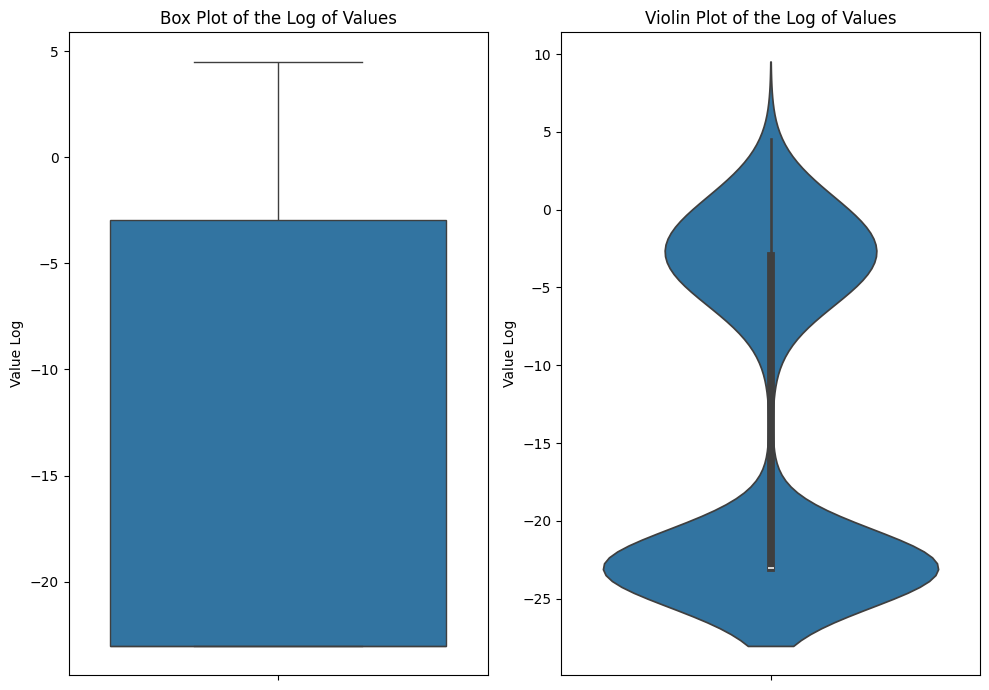

In [22]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(df["Value Log"])
plt.title("Box Plot of the Log of Values")
plt.subplot(1, 2, 2)
sns.violinplot(df["Value Log"])
plt.title("Violin Plot of the Log of Values")
plt.tight_layout()
plt.show()

We can see our data distribution a lot more clearly now. The box plot shows that we don't have any outliers. In the Violin plot we can see that we actually have a bimodal distribution, one around -2.5 and one around -22.5. We could not see that in our original box plots and violin plots. This is where we can see the benefits of logarithm modifications. 

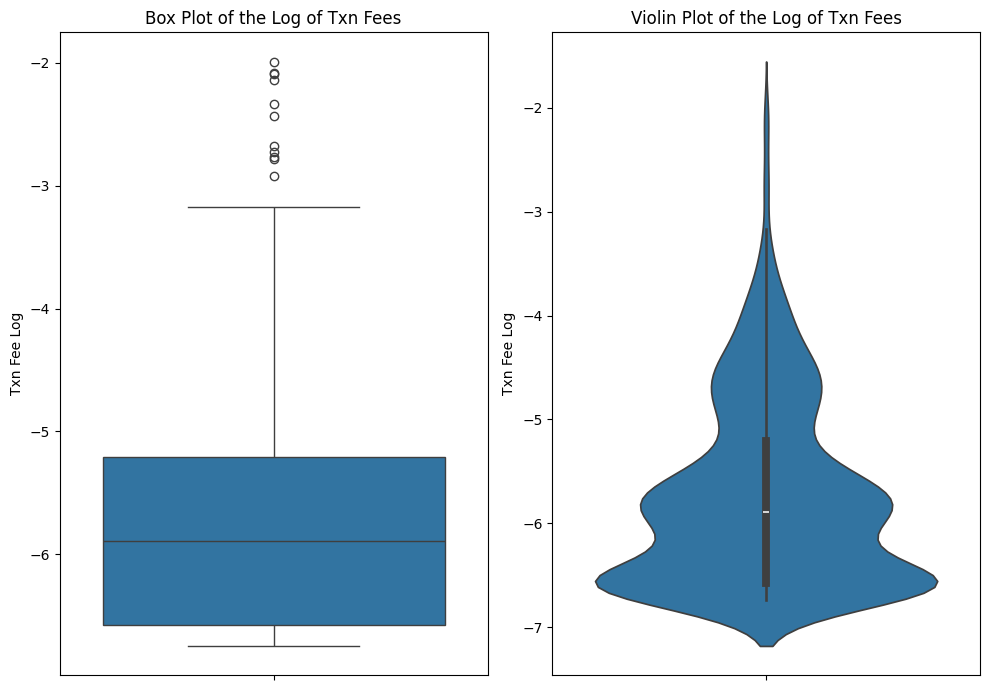

In [23]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(df["Txn Fee Log"])
plt.title("Box Plot of the Log of Txn Fees")
plt.subplot(1, 2, 2)
sns.violinplot(df["Txn Fee Log"])
plt.title("Violin Plot of the Log of Txn Fees")
plt.tight_layout()
plt.show()

The box plot shows that we have significant outliers that are larger than the the other fees. In the Violin plot we can see that our data has three peaks that keep getting smaller and smaller as we approach larger fees. This confirms that our data is right skewed once again. 

4. **Extra Graphs and Analyses**: 

Now that we've done the required graphs and analyses, we can do a few more analyses that explain various questions mainly regarding the significant number of outliers we have in our data.

First we'll do a fee-value plot that will show us the relation between these two.

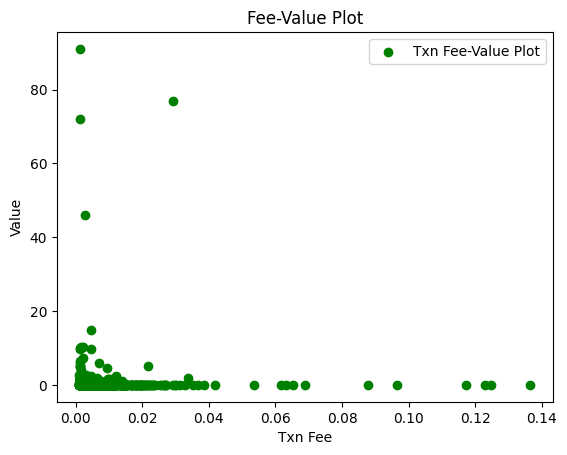

In [24]:
plt.scatter(df["Txn Fee"], df["Value"], color='green', label='Txn Fee-Value Plot')
plt.title('Fee-Value Plot')
plt.xlabel('Txn Fee')
plt.ylabel('Value')
plt.legend()
plt.show()


As the graph shows there's little correlation between fees and value. The only correlations we *may* be able to make are that if we have higher values, then the fees are probably smaller than the mean and if we have higher fees, then the values are low.

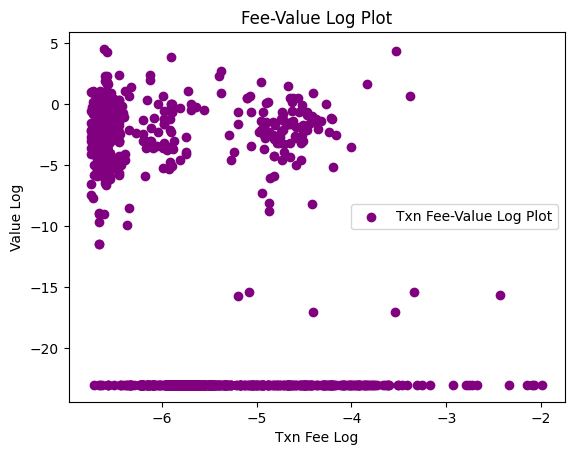

In [25]:
plt.scatter(df["Txn Fee Log"], df["Value Log"], color='purple', label='Txn Fee-Value Log Plot')
plt.title('Fee-Value Log Plot')
plt.xlabel('Txn Fee Log')
plt.ylabel('Value Log')
plt.legend()
plt.show()


This log graph does show better distribution between fee and value and that rows that have 0 value can have very different fees. But it still doesn't show much correlation between value and fee.

We can also check the distribution of the method column using a bar plot graph. Since it has too many different values we'll only do the top 10. This shows us that the overwhelming number of them are transfers, and few are approve and execute, and the rest are negligible. 

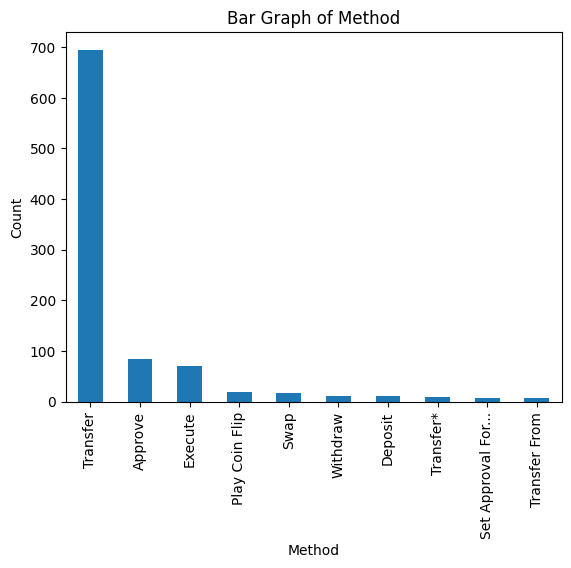

In [26]:
top_10_values_method = df['Method'].value_counts().nlargest(10)
top_10_values_method.plot(kind='bar')
plt.xlabel('Method')
plt.ylabel('Count')
plt.title('Bar Graph of Method')
plt.show()

We'll also check the "to" and "from" columns. As we can see the values for "from" are too diverse to do any meaningful analyses on them or to stratify our sample based on this. For "to" however they are somewhat more dense but not significantly so and thus is only slightly better than "from" should we want to do analyses and stratification based on it.

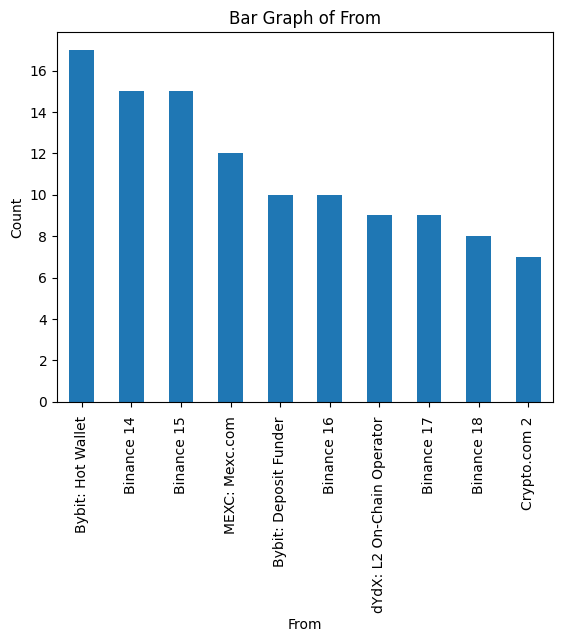

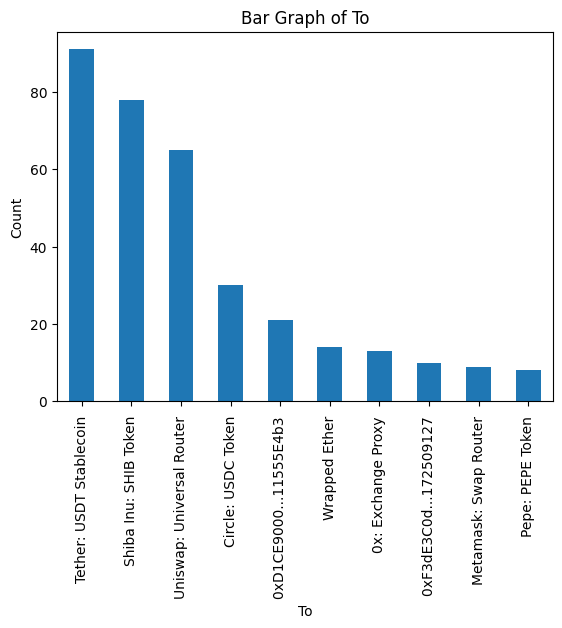

In [27]:
top_10_values_from = df['From'].value_counts().nlargest(10)
top_10_values_from.plot(kind='bar')
plt.xlabel('From')
plt.ylabel('Count')
plt.title('Bar Graph of From')
plt.show()

top_10_values_to = df['To'].value_counts().nlargest(10)
top_10_values_to.plot(kind='bar')
plt.xlabel('To')
plt.ylabel('Count')
plt.title('Bar Graph of To')
plt.show()

And lastly, we should see if there's a correlation between fee and method, and value and method. We'll draw the scatter plots for both of them and see if we can find anything.

In [28]:
#top_5_methods = df['Method'].value_counts().nlargest(5).index
#df_top_5 = df[df['Method'].isin(top_5_methods)]
#
#sns.swarmplot(x='Method', y='Value', data=df_top_5)
#plt.xlabel('Method')
#plt.ylabel('Value')
#plt.title('Swarm Plot with Top 5 Methods and Value')
#
#sns.swarmplot(x='Method', y='Txn Fee', data=df_top_5)
#plt.xlabel('Method')
#plt.ylabel('Txn Fee')
#plt.title('Swarm Plot with Top 5 Methods and Txn Fee')

##### 4. Sample Data Analysis:

We want to take a few sample and see how accurately they can predict our value and fee mean. We'll sample 5% of our population since if the sample size's too large it will undermine the independence of our samples and if it's too small our mean and standard deviation will be far off. We'll give our sample the same random_state to ensure reproducibility

The first sample will be a simple random sample which means everyone in our population has an equal chance at being picked and no stratification will be done on our population

In [29]:
def compare_to_population(column, pop_mean, pop_std, sample_mean, sample_std):
    result_message = (
        f"Mean of population {column}: {pop_mean}\n"
        f"Standard Deviation of population {column}: {pop_std}\n\n"
        f"Mean of sample {column}: {sample_mean}\n"
        f"Standard Deviation of sample {column}: {sample_std}\n\n"
    )

    print(result_message)


sample_size = int(np.ceil(population_size * 0.05))
print(f"sample size: {sample_size}")
sampled_data = df.sample(n = sample_size, random_state = 444)

sample_sizes = sampled_data.groupby('Method').size()
print(f"{sample_sizes}\n\n")

sample_mean_value = sampled_data["Value"].mean()
sample_std_value = sampled_data["Value"].std()

sample_mean_fee = sampled_data["Txn Fee"].mean()
sample_std_fee = sampled_data["Txn Fee"].std()

compare_to_population("Value", pop_mean_value, pop_std_value, sample_mean_value, sample_std_value)
compare_to_population("Txn Fee", pop_mean_fee, pop_std_fee, sample_mean_fee, sample_std_fee)

sample size: 58
Method
0x0a6774d2              1
Approve                 3
Call                    1
Cancel                  1
Claim And Stake         1
Create Proxy Wit...     1
Deposit                 1
Exec Transaction        1
Execute                 2
Exit                    1
Grant Role              1
Mint                    1
Process Route           1
Purchase Token W...     1
Refund                  1
Set Approval For...     1
Start Auction           1
Transfer               36
Transfer From           1
Transfer*               1
dtype: int64


Mean of population Value: 0.49022609499224135
Standard Deviation of population Value: 4.405093152322067

Mean of sample Value: 1.1396304373793102
Standard Deviation of sample Value: 6.083005519058725


Mean of population Txn Fee: 0.005566154887931034
Standard Deviation of population Txn Fee: 0.010348876525458543

Mean of sample Txn Fee: 0.0063505648275862065
Standard Deviation of sample Txn Fee: 0.016466428087444352




Just from looking at it we can guess that this sample is accurately representing Txn fee, but the sample's mean value is a bit bigger than population's mean value. But we need to be extra sure that this is a good sample. So we have to check that our mean is within the confidence interval of our population. If it is then this isn't an outlier sample.

In order to see if they fall within or out of the 95% confidence interval we need to do some calculations. What we need to do is calculate the critical value based on our confidence level, calculate the margin of error using the critical value, std and sample size, and then we calculate our interval by reducing and increasing the sample mean.

We can then see that the value and fee means are within the interval and thus this is a good sample of our population

In [30]:
def check_confidence_interval(confidence_level, pop_mean, sample_size, sample_std, sample_mean, column):
    critical_value = t.ppf((1 + confidence_level) / 2, df=sample_size - 1)

    margin_of_error = critical_value * (sample_std / np.sqrt(sample_size))
    confidence_interval = (sample_mean - margin_of_error, sample_mean + margin_of_error)

    if confidence_interval[0] <= pop_mean <= confidence_interval[1]:
        print("The population " +  column + " mean is within the 95% confidence interval of the sample.")
    else:
        print("The population " +  column + " mean is not within the 95% confidence interval of the sample.")


check_confidence_interval(0.95, pop_mean_value, sample_size, sample_std_value, sample_mean_value, "value")
check_confidence_interval(0.95, pop_mean_fee, sample_size, sample_std_fee, sample_mean_fee, "fee")

The population value mean is within the 95% confidence interval of the sample.
The population fee mean is within the 95% confidence interval of the sample.


The next sample we'll take is a stratified sample. Based on our data we know that the only stratification that makes sense is based on "method". The rest are either (almost) unique to each row like hash, from, and to, or were dependent on when we scrapped the website for data like block number and age.

We attempted a stratified sample based on "to" but because of the varied values it had a very small sample size which proved it was a bad way to stratify

In [37]:
stratified_sample = df.groupby('Method', group_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=10))
sample_sizes = stratified_sample.groupby('Method').size()
stratified_sample_size = sample_sizes.sum()
print(f"{sample_sizes}\n{stratified_sample_size}\n")

Method
Approve            4
Deposit            1
Execute            4
Play Coin Flip     1
Swap               1
Transfer          35
Withdraw           1
dtype: int64
47



C:\Users\Arash-PC\AppData\Local\Temp\ipykernel_9096\1522872092.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = df.groupby('Method', group_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=10))


In [ ]:
def compare_to_population_and_SRS(column, pop_mean, pop_std, SSR_mean, SSR_std, stratified_mean, stratified_std):
    result_message = (
        f"Mean of population {column}: {pop_mean}\n"
        f"Standard Deviation of population {column}: {pop_std}\n\n"
        f"Mean of SRS {column}: {SSR_mean}\n"
        f"Standard Deviation of SRS {column}: {SSR_std}\n\n"
        f"Mean of Stratified Sample {column}: {stratified_mean}\n"
        f"Standard Deviation of Stratified Sample {column}: {stratified_std}\n\n"
    )
    
    print(result_message)

stratified_sample_mean_value = stratified_sample['Value'].mean()
stratified_sample_std_value = stratified_sample['Value'].std()

stratified_sample_mean_fee = stratified_sample['Txn Fee'].mean()
stratified_sample_std_fee = stratified_sample['Txn Fee'].std()

compare_to_population_and_SRS("Value", pop_mean_value, pop_std_value, sample_mean_value, sample_std_value, stratified_sample_mean_value, stratified_sample_std_value)
compare_to_population_and_SRS("Txn Fee", pop_mean_fee, pop_std_fee, sample_mean_fee, sample_std_fee, stratified_sample_mean_fee, stratified_sample_std_fee)

Mean of population Value: 0.49022609499224135
Standard Deviation of population Value: 4.405093152322067

Mean of SRS Value: 1.1396304373793102
Standard Deviation of SRS Value: 6.083005519058725

Mean of Stratified Sample Value: 0.26405936576595745
Standard Deviation of Stratified Sample Value: 0.795540887416816


Mean of population Txn Fee: 0.005566154887931034
Standard Deviation of population Txn Fee: 0.010348876525458543

Mean of SRS Txn Fee: 0.0063505648275862065
Standard Deviation of SRS Txn Fee: 0.016466428087444352

Mean of Stratified Sample Txn Fee: 0.003956751914893617
Standard Deviation of Stratified Sample Txn Fee: 0.00553502958243249




We see that the stratified value mean is lower than the srs mean and is closer to the population value mean. For Txn Fee the stratified mean is lower then both the pop mean and the srs mean but it's as far away from the pop mean as the srs mean is. The standard deviation for both of them are significantly lower than both the population and the simple sampling, meaning that our stratum's may not include the larger outliers.

Just to make sure the sample's still good we have to check with the confidence interval. We can then see that the value and fee means are within the interval and thus this is a good sample of our population

In [ ]:
check_confidence_interval(0.95, pop_mean_value, stratified_sample_size, stratified_sample_std_value, stratified_sample_mean_value, "value")
check_confidence_interval(0.95, pop_mean_fee, stratified_sample_size, stratified_sample_std_fee, stratified_sample_mean_fee, "fee")

The population value mean is within the 95% confidence interval of the sample.
The population fee mean is within the 95% confidence interval of the sample.


Now we'll do the histograms, box plots and violin plots:

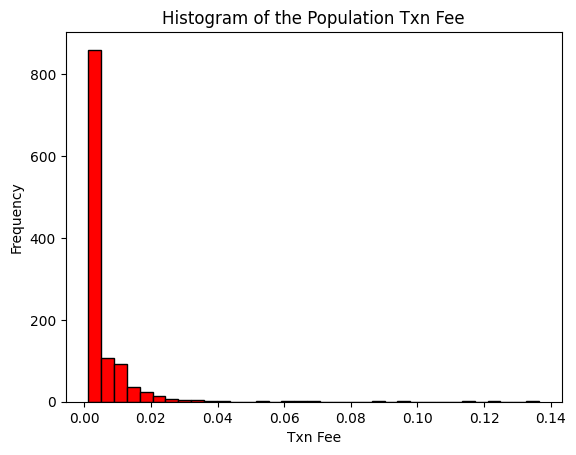

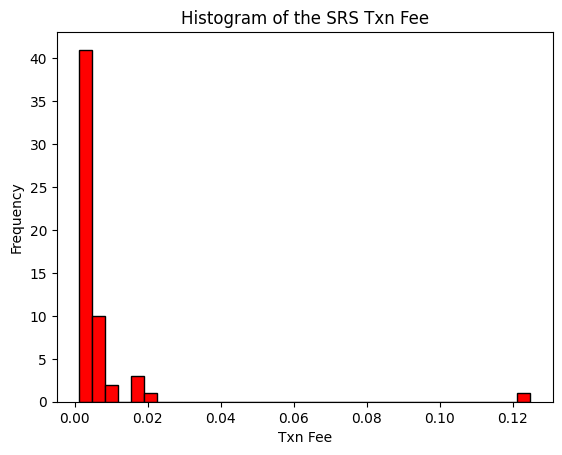

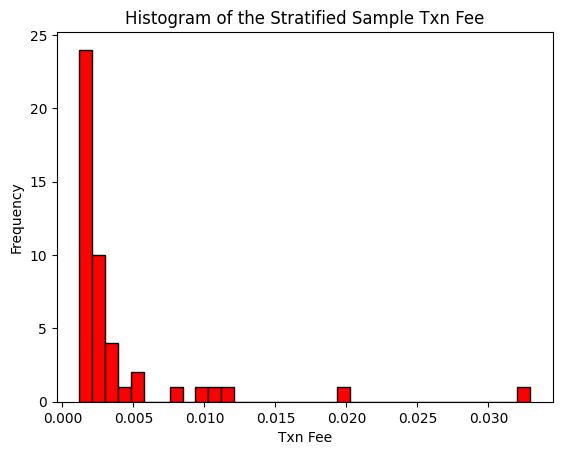

In [ ]:
plt.hist(df["Txn Fee"], bins=sq_root_of_pop, color='red', edgecolor='black')
plt.xlabel('Txn Fee')
plt.ylabel('Frequency')
plt.title('Histogram of the Population Txn Fee')
plt.show()

plt.hist(sampled_data["Txn Fee"], bins=sq_root_of_pop, color='red', edgecolor='black')
plt.xlabel('Txn Fee')
plt.ylabel('Frequency')
plt.title('Histogram of the SRS Txn Fee')
plt.show()

plt.hist(stratified_sample["Txn Fee"], bins=sq_root_of_pop, color='red', edgecolor='black')
plt.xlabel('Txn Fee')
plt.ylabel('Frequency')
plt.title('Histogram of the Stratified Sample Txn Fee')
plt.show()

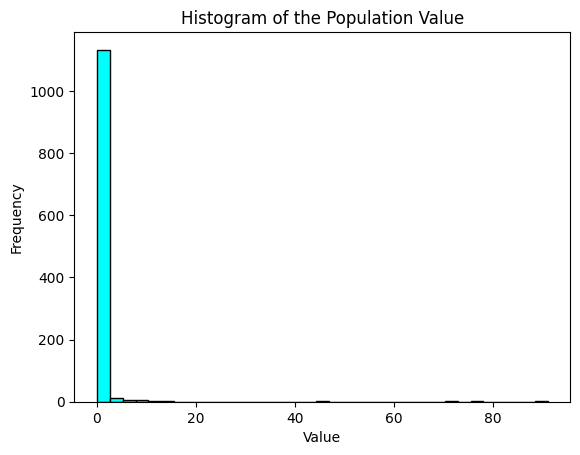

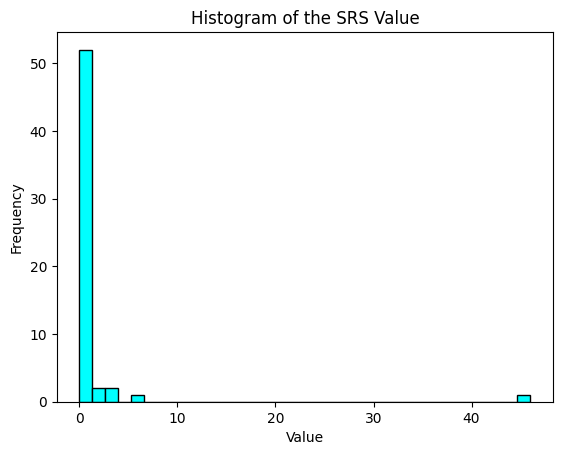

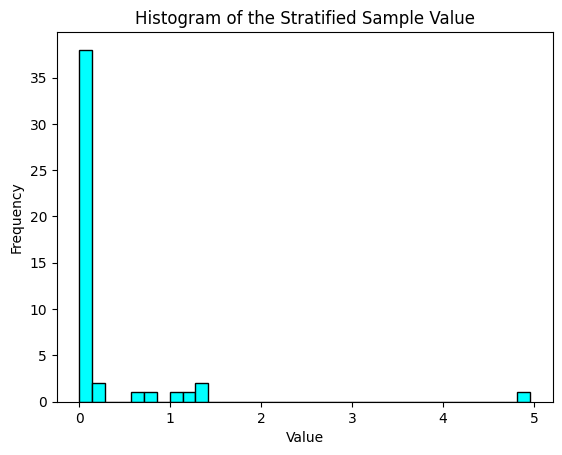

In [ ]:
plt.hist(df["Value"], bins=sq_root_of_pop, color='cyan', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of the Population Value')
plt.show()

plt.hist(sampled_data["Value"], bins=sq_root_of_pop, color='cyan', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of the SRS Value')
plt.show()

plt.hist(stratified_sample["Value"], bins=sq_root_of_pop, color='cyan', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of the Stratified Sample Value')
plt.show()

At first it may seem like our simple sample's closer to our population's distribution than the stratified sample is, but if you take a closer look at the x axis you can see that the stratified sample might in fact be more similar. Although it does lack the outlier we see in our population, thus explaining the much lower standard deviation, it is closer to the real distribution otherwise. Keep in mind that it's they aren't too different and thus we can't say for certain which one's a better sample according to the histogram

Now we'll do the log histograms just in case:

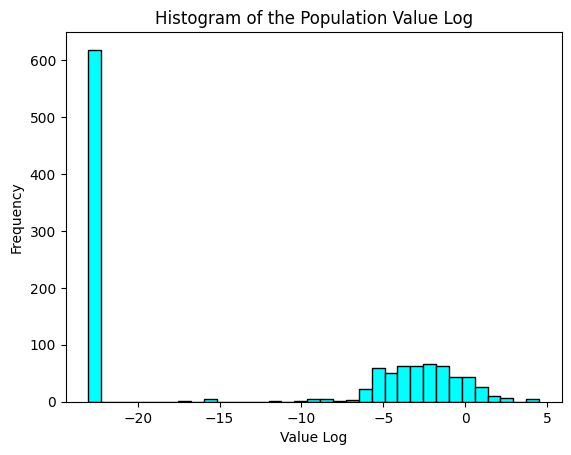

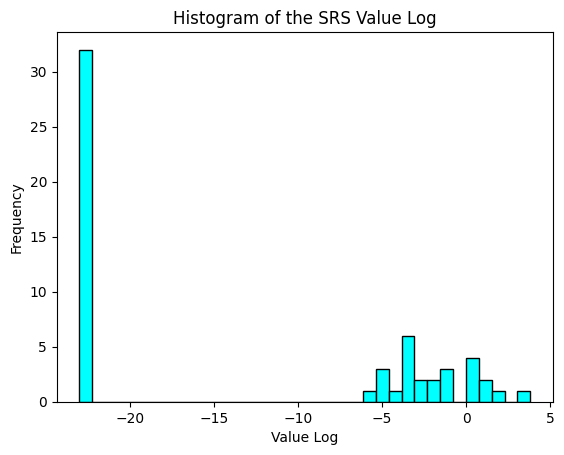

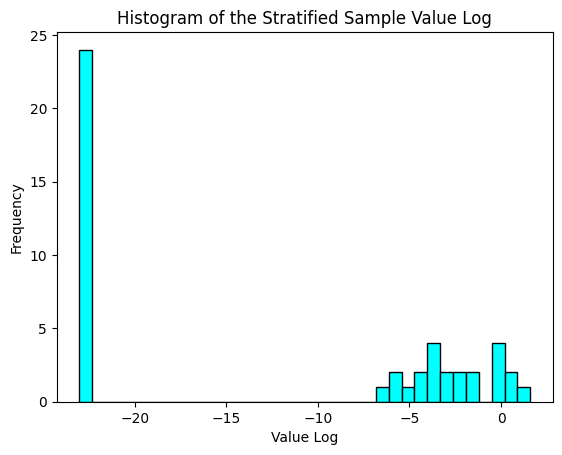

In [ ]:
plt.hist(df["Value Log"], bins=sq_root_of_pop, color='cyan', edgecolor='black')
plt.xlabel('Value Log')
plt.ylabel('Frequency')
plt.title('Histogram of the Population Value Log')
plt.show()

plt.hist(sampled_data["Value Log"], bins=sq_root_of_pop, color='cyan', edgecolor='black')
plt.xlabel('Value Log')
plt.ylabel('Frequency')
plt.title('Histogram of the SRS Value Log')
plt.show()

plt.hist(stratified_sample["Value Log"], bins=sq_root_of_pop, color='cyan', edgecolor='black')
plt.xlabel('Value Log')
plt.ylabel('Frequency')
plt.title('Histogram of the Stratified Sample Value Log')
plt.show()

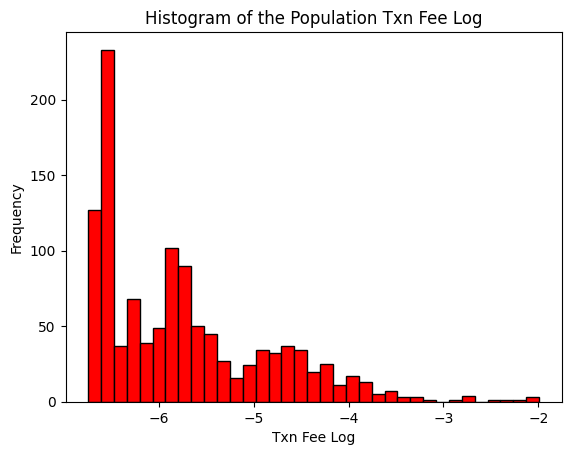

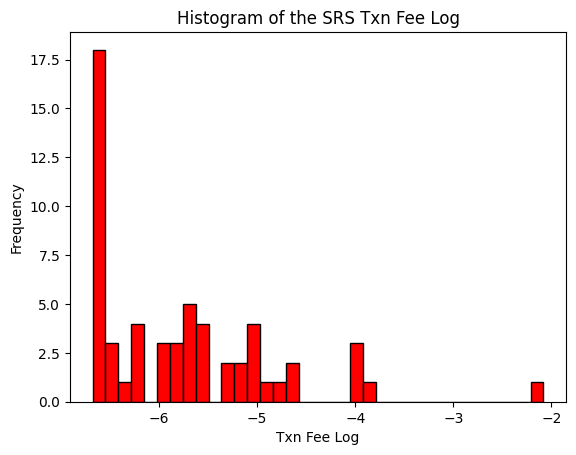

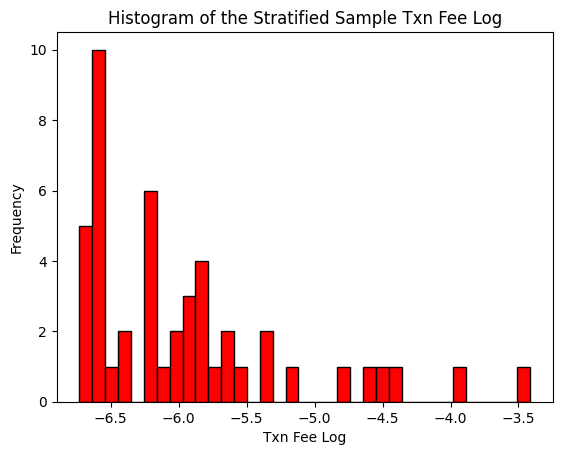

In [ ]:
plt.hist(df["Txn Fee Log"], bins=sq_root_of_pop, color='red', edgecolor='black')
plt.xlabel('Txn Fee Log')
plt.ylabel('Frequency')
plt.title('Histogram of the Population Txn Fee Log')
plt.show()

plt.hist(sampled_data["Txn Fee Log"], bins=sq_root_of_pop, color='red', edgecolor='black')
plt.xlabel('Txn Fee Log')
plt.ylabel('Frequency')
plt.title('Histogram of the SRS Txn Fee Log')
plt.show()

plt.hist(stratified_sample["Txn Fee Log"], bins=sq_root_of_pop, color='red', edgecolor='black')
plt.xlabel('Txn Fee Log')
plt.ylabel('Frequency')
plt.title('Histogram of the Stratified Sample Txn Fee Log')
plt.show()

With the log histograms we can clearly see that stratified samples are quite better than simple samples, especially when it comes to TXN fees. Just comparing the first bin alone in TXN fees is quite telling. Once again we can't say for certain which one's truly better but so far we have further evidence that stratified samples are better than simple samples

Now onto box plots and violin plots:

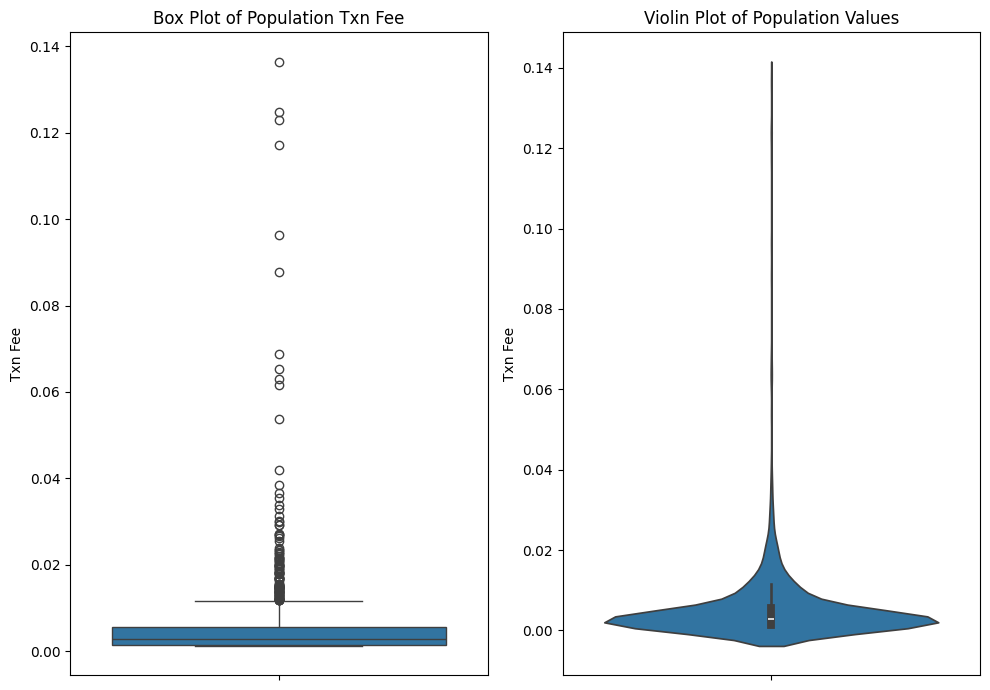

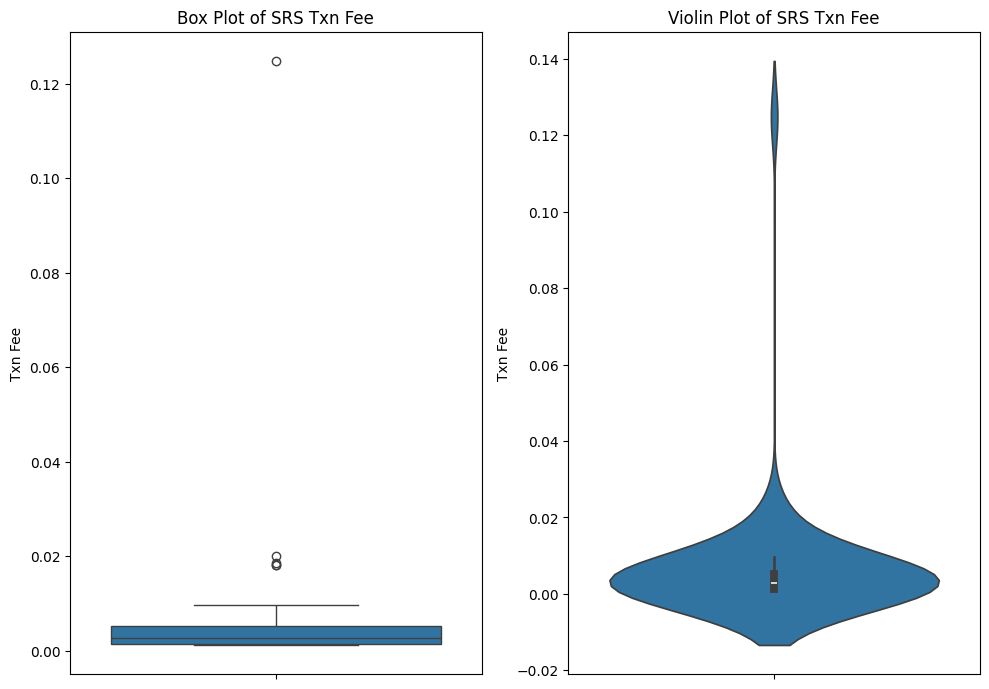

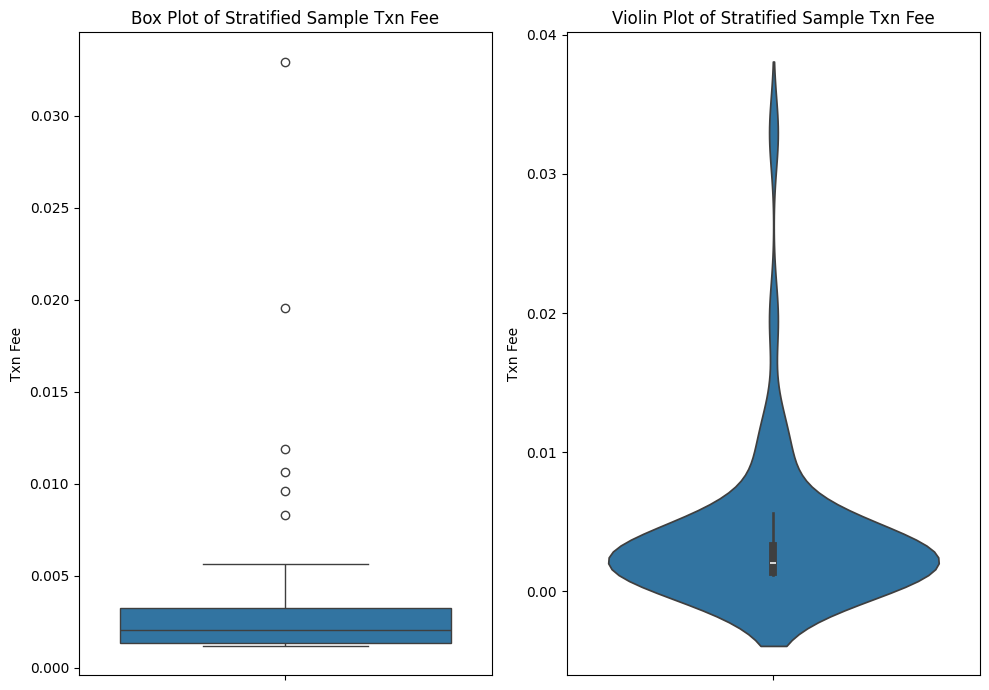

In [ ]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(df["Txn Fee"])
plt.title("Box Plot of Population Txn Fee")
plt.subplot(1, 2, 2)
sns.violinplot(df["Txn Fee"])
plt.title("Violin Plot of Population Values")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(sampled_data["Txn Fee"])
plt.title("Box Plot of SRS Txn Fee")
plt.subplot(1, 2, 2)
sns.violinplot(sampled_data["Txn Fee"])
plt.title("Violin Plot of SRS Txn Fee")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(stratified_sample["Txn Fee"])
plt.title("Box Plot of Stratified Sample Txn Fee")
plt.subplot(1, 2, 2)
sns.violinplot(stratified_sample["Txn Fee"])
plt.title("Violin Plot of Stratified Sample Txn Fee")
plt.tight_layout()
plt.show()

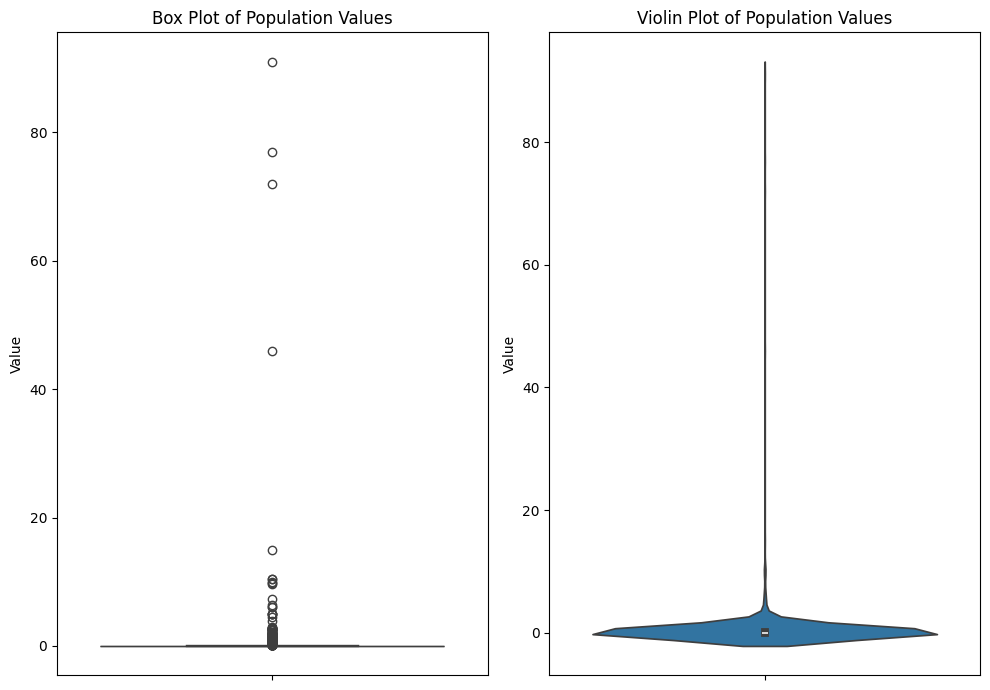

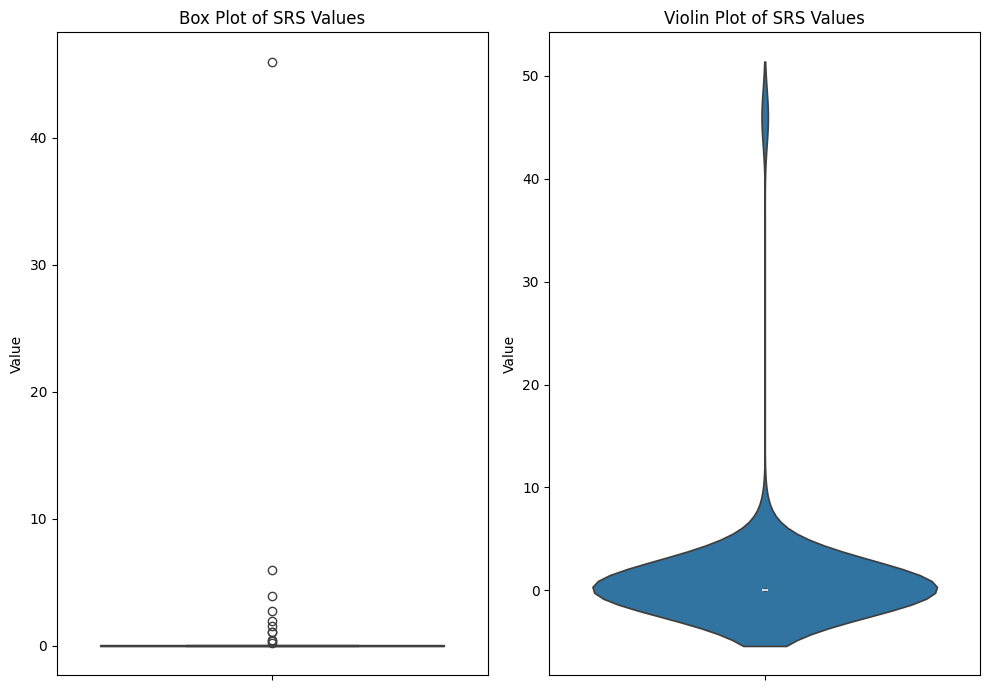

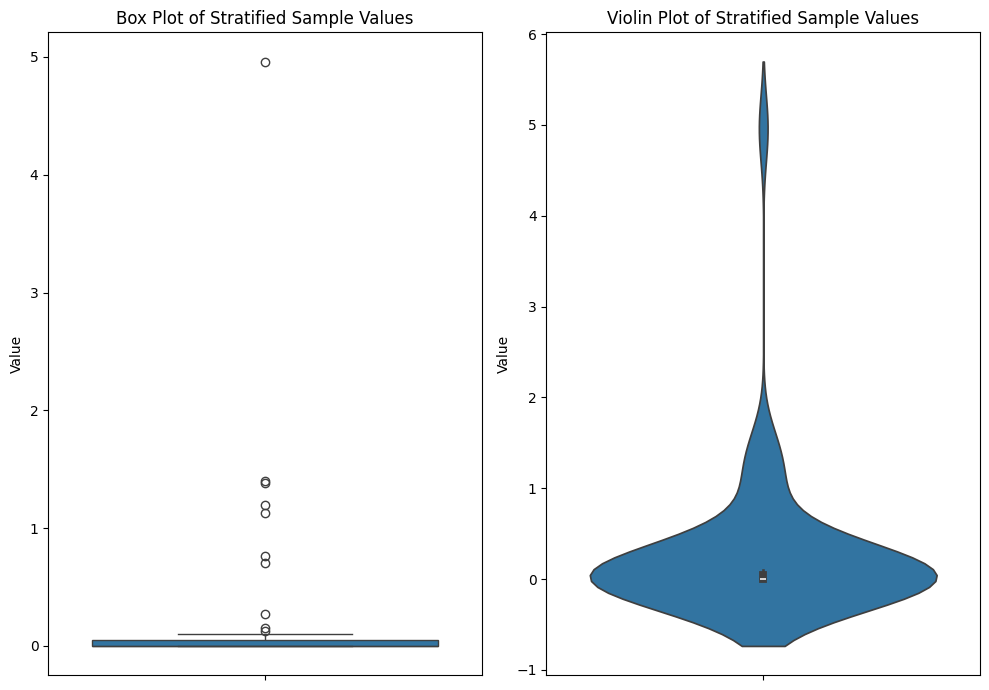

In [ ]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(df["Value"])
plt.title("Box Plot of Population Values")
plt.subplot(1, 2, 2)
sns.violinplot(df["Value"])
plt.title("Violin Plot of Population Values")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(sampled_data["Value"])
plt.title("Box Plot of SRS Values")
plt.subplot(1, 2, 2)
sns.violinplot(sampled_data["Value"])
plt.title("Violin Plot of SRS Values")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(stratified_sample["Value"])
plt.title("Box Plot of Stratified Sample Values")
plt.subplot(1, 2, 2)
sns.violinplot(stratified_sample["Value"])
plt.title("Violin Plot of Stratified Sample Values")
plt.tight_layout()
plt.show()

Similarly to the histograms, we can see that the distribution of the stratified sample might be closer to the population than the simple one but they're even more similar to each other in this case. The simple sample is more spread out compared to the more compact stratified sample if we take a closer look at the y axis. And once again, we have less outliers in both samples but much more so in the stratified sample.

Just to be safe we'll do the log violin and box plots just to make sure we're not missing anything since the non-log versions of them were quite similar to one another

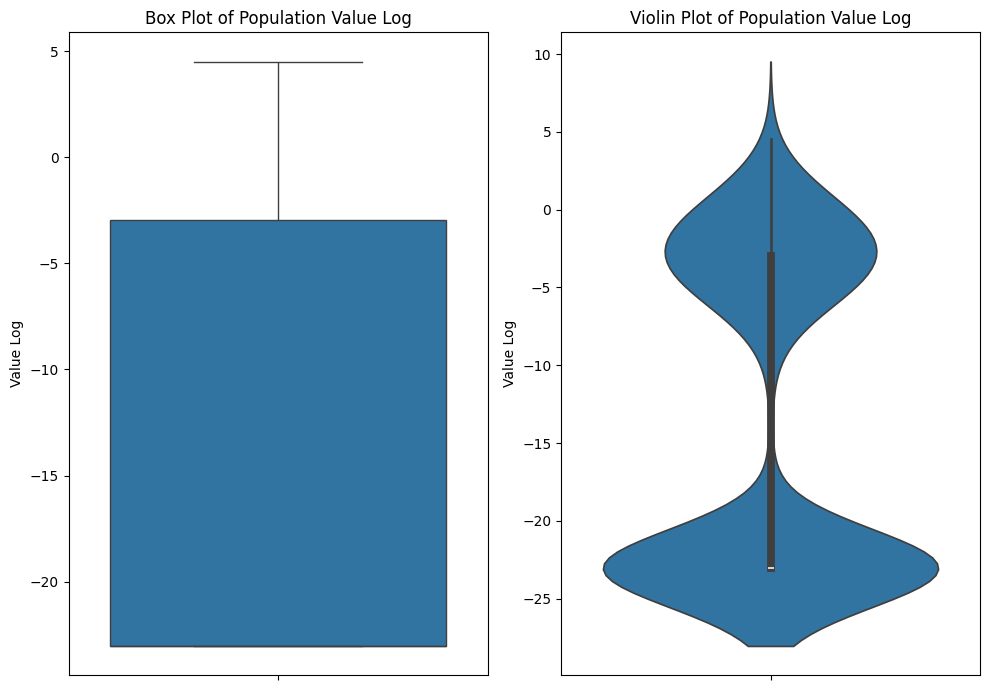

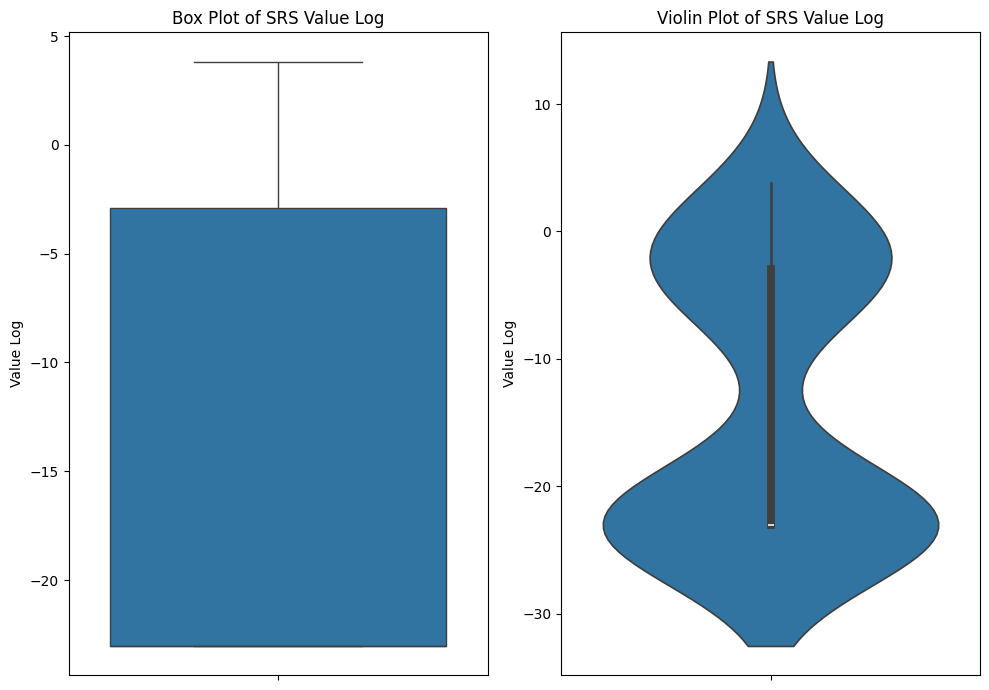

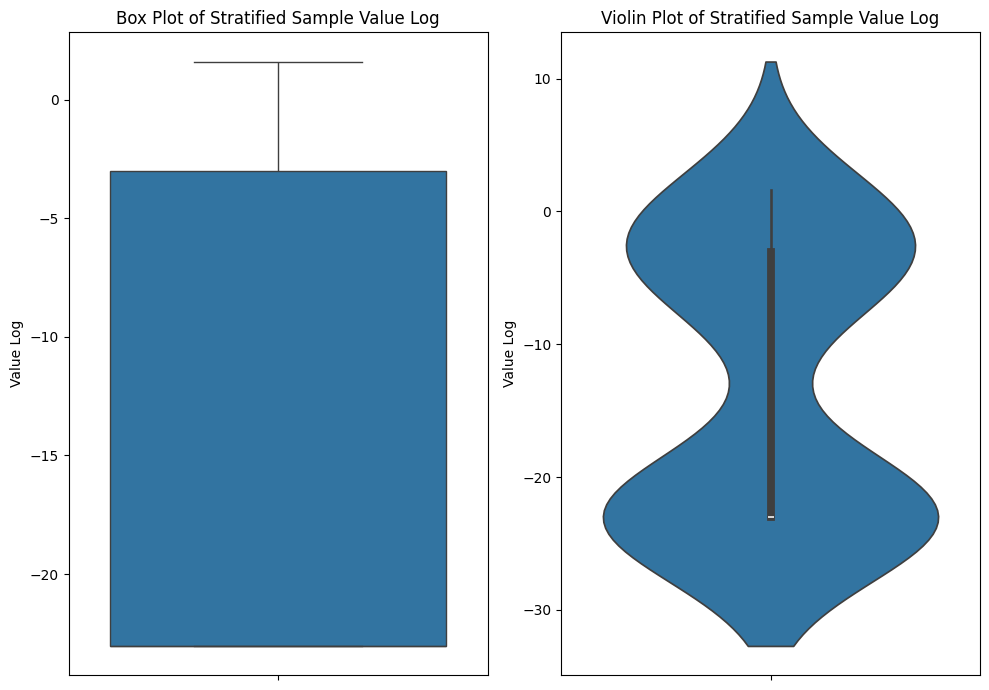

In [ ]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(df["Value Log"])
plt.title("Box Plot of Population Value Log")
plt.subplot(1, 2, 2)
sns.violinplot(df["Value Log"])
plt.title("Violin Plot of Population Value Log")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(sampled_data["Value Log"])
plt.title("Box Plot of SRS Value Log")
plt.subplot(1, 2, 2)
sns.violinplot(sampled_data["Value Log"])
plt.title("Violin Plot of SRS Value Log")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(stratified_sample["Value Log"])
plt.title("Box Plot of Stratified Sample Value Log")
plt.subplot(1, 2, 2)
sns.violinplot(stratified_sample["Value Log"])
plt.title("Violin Plot of Stratified Sample Value Log")
plt.tight_layout()
plt.show()

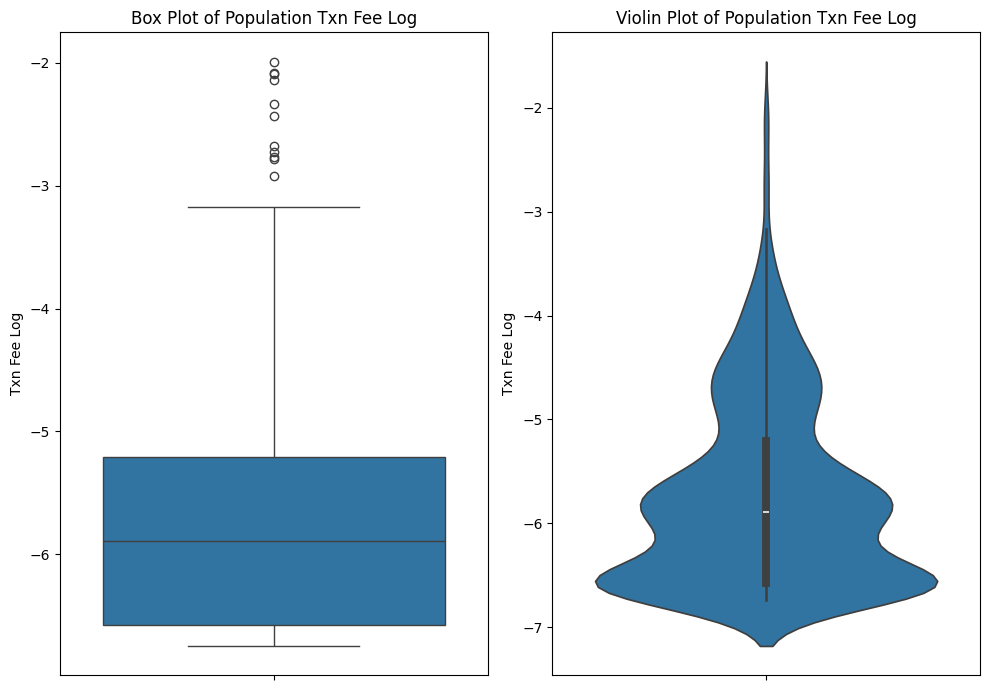

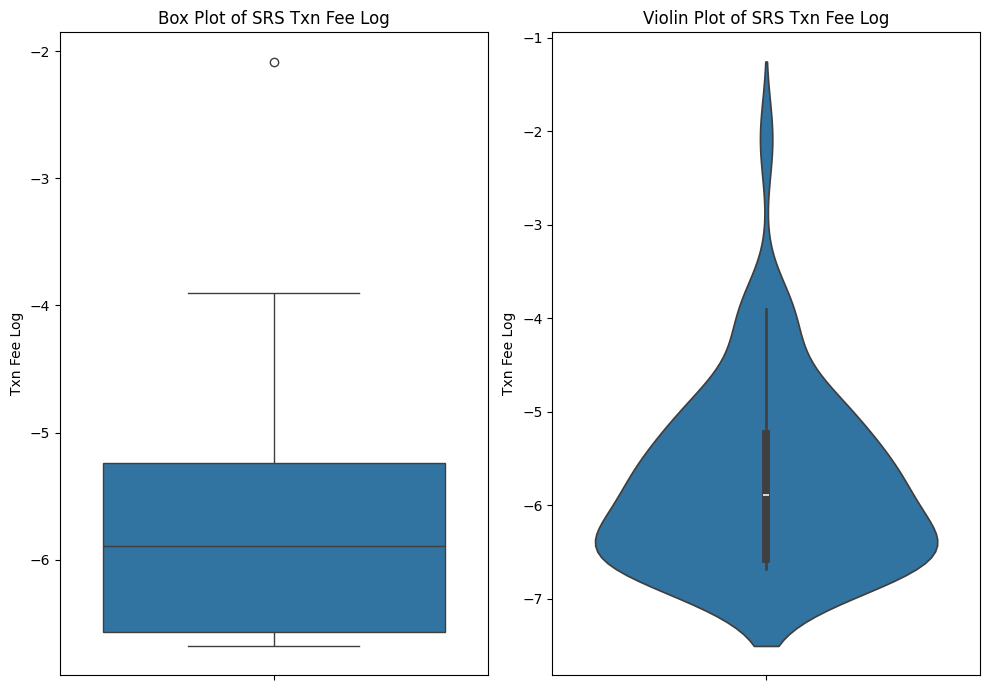

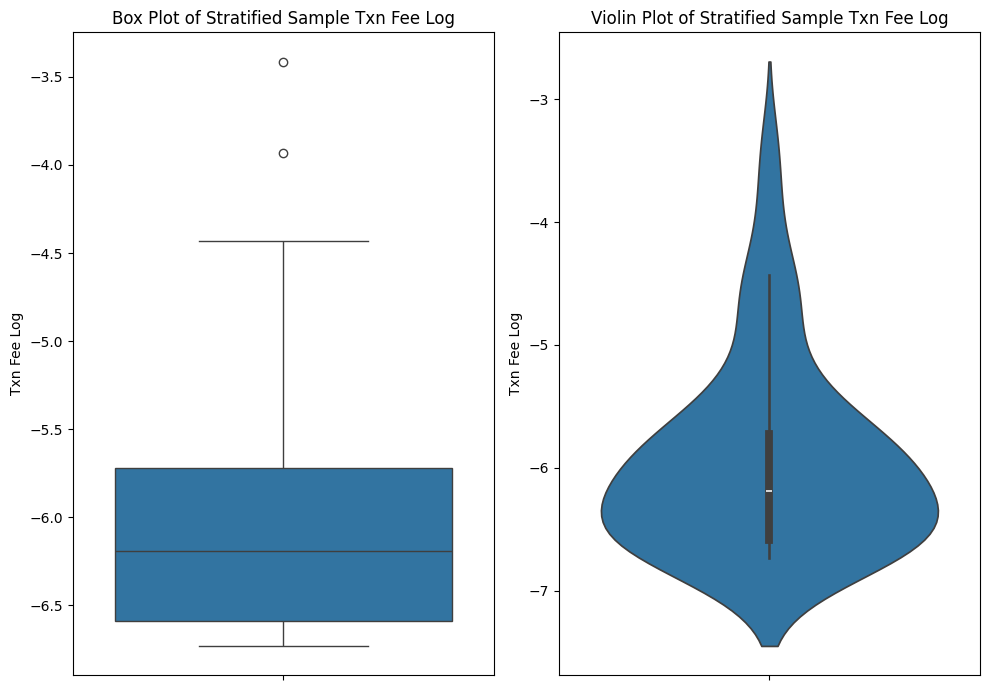

In [ ]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(df["Txn Fee Log"])
plt.title("Box Plot of Population Txn Fee Log")
plt.subplot(1, 2, 2)
sns.violinplot(df["Txn Fee Log"])
plt.title("Violin Plot of Population Txn Fee Log")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(sampled_data["Txn Fee Log"])
plt.title("Box Plot of SRS Txn Fee Log")
plt.subplot(1, 2, 2)
sns.violinplot(sampled_data["Txn Fee Log"])
plt.title("Violin Plot of SRS Txn Fee Log")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(stratified_sample["Txn Fee Log"])
plt.title("Box Plot of Stratified Sample Txn Fee Log")
plt.subplot(1, 2, 2)
sns.violinplot(stratified_sample["Txn Fee Log"])
plt.title("Violin Plot of Stratified Sample Txn Fee Log")
plt.tight_layout()
plt.show()

In these plots they once again look strikingly similar, this time however the simple sample was the closer one to the population. 

Therefore it seems like the stratified sample and simple sample have similar distributions in box and violin plots that make a clear analysis impossible

## Questions

#### Question 1: What are some potential limitations when using web scraping for data collection? Specifically, what problems did you face while fetching data from Etherscan? What problems can these limitations cause in your analysis?

There are a few limitations. The first one is rate limiting and anti-bot measures, which can prevent us from scrapping data. Rate limits can impede our scrapping speed and make it tedious. Anti-bot measures can kick us out or even ban us from the website, preventing us from getting any data. Rate limits can be overcome with coding sleeps as low as 1 second, as we've done in our code. This tricks the website into thinking that we're just a normal user navigating their website. Etherscan doesn't have strong anti-bot measures, and usually there's no anti-bot verifications. They only show up when you're using a vpn and disconnecting it will solve the problem.

Navigating pages can be time consuming and hard to code properly. Etherscan is quite fast and every second there are new transactions being added to the site. These two problems combine into a new problem, that while we're navigating through the pages, new data's being added to etherscan. This data might belong to our first block and so our first block might be smaller than it should've been. The other problem is that due to the high speed etherscan has when it comes to adding data, we may read for example page 5 and get all of its data, but when we go to the next page, 10 new block have been added to the first page, meaning that the last 10 data of page 5 will be moved to the next page, and so we'll read and add the 10 data again, causing duplications.

#### Question 2: What can make your analysis untrustworthy? What are your solutions?

One of the things that might make it untrustworthy is that we're not scrapping all data, but the first 10 blocks we see. This would make our population dependent on when we scrapped the website. Maybe some transactions are more prevalent during some time periods or maybe some countries are more active during different time periods and have different transactions. We can either increase our population size for all of it which can be very costly or we can scrap during different times of the day or stratify it for different times of day.

Some that we mentioned above are duplications, which is undesirable as we want each data to be unique, and missing new data, which makes our first block smaller and less accurate than it actually is. What we can do for the first problem is to drop them using the panda command drop_duplicate(), and for the second one we loop on the first page and keep refreshing it until a completely new block number arrives to ensure that we have all the block from the first data.

reproducibility is quite important, which means we need to save our collected data into a csv file so we can read it when we want to. Otherwise if we want to show someone our analyses and they demand to see proof, we won't be able to reproduce it as we didn't save our data. As stated before etherscan data's are updated quite frequently and running the scrapping algorithm again will scrap entirely new data, meaning that we have to do our analyses again.

#### Question 3: How did the visualization help you in understanding the data? What could you interpret from the plots?

Visualization helped us see what the distribution of our data is like and the analyses we can make. It helped us understand that for example that Txn fees and values are quite small but they do have outliers that are considerably larger. In addition a lot of our values are extremely small and are in the first bin, compared to the more varied Txn fee. We also found out that most of them are float number smaller than 1 and only few of them are over 1. 

Then we did a log transformation (and added a small constant to value so we could calculate the log of values there were 0) for that and it strengthened our previous analyses more. Most of our values were 0 and if we disregarded it the log graph followed a normal function with smaller outliers. Fees on the other hand followed a somewhat decreasing path, as higher fees had a lower frequency.

Next we did box and violin plots. For the non transformed data, we could clearly see how dense it is around smaller numbers as we can't even see the box plot. It'd be more accurate to call it the line plot in this case. The same goes for the violin plot. We can also see that a lot of our data's considered an outlier because of the massive density. Once again values are much more dense than Txn fees.

Then we plotted the log data, which allows us to see the smaller data in a much better way. We can see that the log of our small data in values is bimodal and that they're almost equally divided between these two peaks. The Txn fee log is also a decreasing distribution with three peaks. We can actually see the box plot this time, and it tells us that the log values don't have any outliers and that smaller numbers are more significant. For Txn fees it does show us outliers that are larger numbers and once again that fees are mainly smaller numbers.

We did these for our two samples as well, but we'll delve into them in the next question.

#### Question 4: How do the two sampling methods differ in their output? Compare these and explain which one is a better fit to the population.

Disclaimer: It's important to note that based on the description, we only took two samples, one simple and one stratified based on method (we ruled out other stratums previously). We will compare these two methods based only on the two samples we took and nothing else. We can't extrapolate our conclusions to all samples taken from this population, let alone all samples in general. That being said, we can conclude that the stratified sample is somewhat better than the simple sample. 

First we took the mean and std of both samples. We noticed that in value the stratified sample mean of value was closer to the population mean of value than the simple sample. The opposite happened for the Txn fee however as the simple sample mean was closer. We also noticed that in both value and Txn fee the stratified sample had considerably less deviation than the population, while the simple sample had higher deviation.

Second we compared the histograms. We concluded that the stratified sample seems to have more accurately represent our population, because while both samples had similar value distributions, the stratified sample was more accurate when it came to Txn Fee. The only caveat was that it lacked the large outliers present in our population. So we now found out why the stratified sample had much less deviation than the simple sample. We compared the log of these values and it further solidified our analysis. 


Lastly we compared the violin and box plots. These plots are quite similar, and it *seems* like the simple sample might be slightly closer to our population plots than the stratified sample. Because they're alike we consider both of them to be equal in this regard.

Therefore we can conclude that stratified samples have an edge in this analysis we've done. This might be because by stratifying our sample we'll ensure a proper representation of all methods. However because some methods are small and won't be represented in our sample this might result in some inaccuracies. For example, we can now guess say that the methods that have large values and/or fees are miniscule as we didn't get those types of data in our stratified sample.

### Resources

- [Scraping HTML file into pandas dataframe](https://saturncloud.io/blog/how-to-scrape-an-html-table-with-beautiful-soup-into-pandas/)
- [Number of bins in histogram](http://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width)